<a href="https://colab.research.google.com/github/ramirezcarlos292/smart_cat_litterbox/blob/main/pet_human_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
import os
import zipfile

import tensorflow as tf
import os
import shutil
import numpy as np
import keras
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt

# Data Download

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   169M      0  0:00:04  0:00:04 --:--:--  172M


In [3]:
!curl -L -o /content/human-faces.zip https://www.kaggle.com/api/v1/datasets/download/ashwingupta3012/human-faces

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1861M  100 1861M    0     0  19.9M      0  0:01:33  0:01:33 --:--:-- 17.8M


In [6]:
!unzip -q human-faces.zip
!unzip -q kagglecatsanddogs_5340.zip
!ls

 CDLA-Permissive-2.0.pdf   Humans		        PetImages	 sample_data
 human-faces.zip	   kagglecatsanddogs_5340.zip  'readme[1].txt'


# Remove Corrupted files

In [16]:
num_skipped = 0
for folder_name in ("Cat", "Humans"):
    folder_path = os.path.join("data", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1158 images.


In [33]:
# Specify the directory name
def create_folder(directory_name):
  # directory_name = "data"

  # Create the directory
  try:
      os.mkdir(directory_name)
      print(f"Directory '{directory_name}' created successfully.")
  except FileExistsError:
      print(f"Directory '{directory_name}' already exists.")
  except PermissionError:
      print(f"Permission denied: Unable to create '{directory_name}'.")
  except Exception as e:
      print(f"An error occurred: {e}")

In [8]:
def move_data(source):
  destination = '/content/data/'
  dest = shutil.move(source, destination)

source = '/content/PetImages/Dog'
move_data(source)

source = '/content/PetImages/Cat'
move_data(source)

os.rmdir('/content/PetImages/')

source = '/content/Humans'
move_data(source)

In [9]:
for item in os.listdir('/content/data'):
  if item[-3:] == 'jpg':
    os.remove(os.path.join('/content/data/', item))

# Tensorflow

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [17]:
import pathlib
data_dir = pathlib.Path('/content/data').with_suffix('')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

18468


# Data split / prep

In [18]:
batch_size = 32
img_height = 180
img_width = 180

# load data
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 18561 files belonging to 2 classes.
Using 14849 files for training.


In [19]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 18561 files belonging to 2 classes.
Using 3712 files for validation.


# Classes

In [20]:
class_names = train_ds.class_names
print(class_names)

['Cat', 'Humans']


# Data Preview

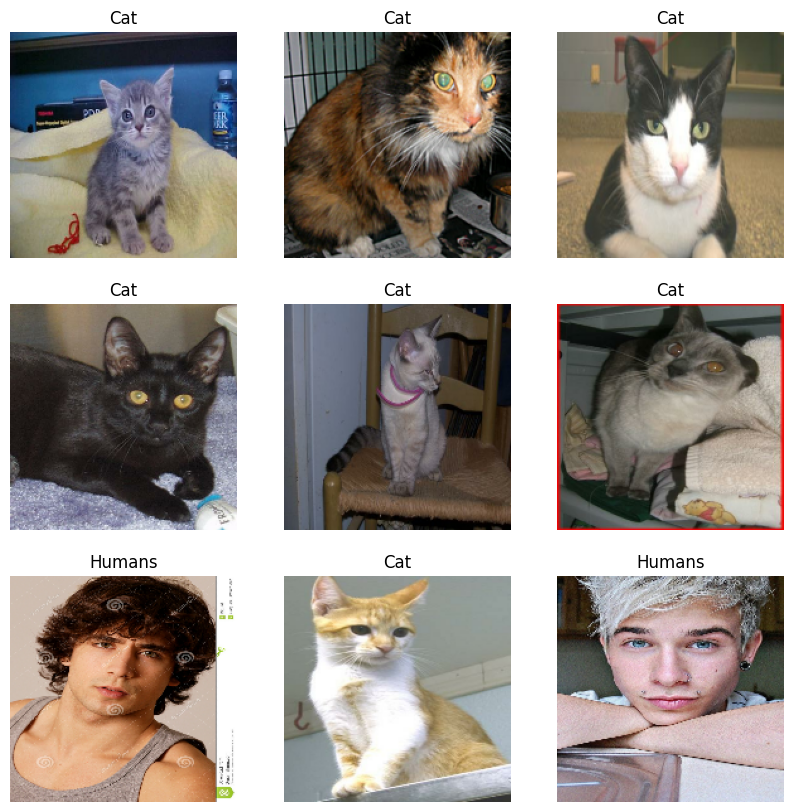

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [22]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


# Standaridize the data

In [23]:
normalization_layer = layers.Rescaling(1./255)

In [24]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.9839873


# Dataset setup for Performance

In [25]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Base Model

In [26]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [27]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [28]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,988,898 (15.22 MB)

 Trainable params: 3,988,898 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
465/465 ━━━━━━━━━━━━━━━━━━━━ 156s 86ms/step - accuracy: 0.8510 - loss: 0.4038 - val_accuracy: 0.9488 - val_loss: 0.1346
Epoch 2/10
465/465 ━━━━━━━━━━━━━━━━━━━━ 55s 17ms/step - accuracy: 0.9710 - loss: 0.0792 - val_accuracy: 0.9655 - val_loss: 0.0903
Epoch 3/10
465/465 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9866 - loss: 0.0368 - val_accuracy: 0.9723 - val_loss: 0.0798
Epoch 4/10
465/465 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.9933 - loss: 0.0180 - val_accuracy: 0.9679 - val_loss: 0.0955
Epoch 5/10
465/465 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9949 - loss: 0.0148 - val_accuracy: 0.9868 - val_loss: 0.0466
Epoch 6/10
465/465 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.9931 - loss: 0.0207 - val_accuracy: 0.9903 - val_loss: 0.0346
Epoch 7/10
465/465 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - accuracy: 0.9992 - loss: 0.0027 - val_accuracy: 0.9836 - val_loss: 0.0628
Epoch 8/10
465/465 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.9947 - loss: 0.0166 - val

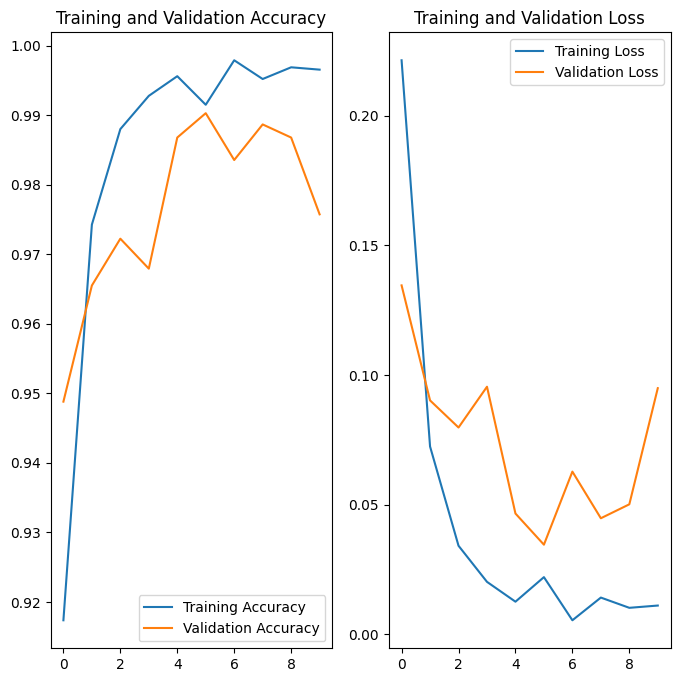

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [34]:
create_folder('models')

model.save('my_model.keras')

# reload model for checking
new_model = tf.keras.models.load_model('my_model.keras')

new_model.summary()

Directory 'models' created successfully.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 180, 180, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 90, 90, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 90, 90, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 45, 45, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,965,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,966,696 (45.65 MB)

 Trainable params: 3,988,898 (15.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,977,798 (30.43 MB)

In [35]:
from google.colab import files
files.download('my_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>